# Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime

# Read the dataset

In [2]:
reg_ev_sum = pd.read_csv('https://raw.githubusercontent.com/wingochau/Dissertation/main/ML_registered_vehicle_sum.csv')
#reg_ev_sum = pd.read_csv('https://raw.githubusercontent.com/wingochau/Dissertation/main/registered_vehicle_sum.csv')

In [12]:
reg_ev_sum = reg_ev_sum.iloc[0:96, :]
reg_ev_sum

,Unnamed: 0,EV,PETROL,DIESEL,period
0,0,292,494222,2291,201301
1,1,297,495909,2292,201302
2,2,297,498394,2296,201303
3,3,303,499553,2292,201304
4,4,304,501271,2294,201305
...,...,...,...,...,...
91,91,15878,612808,11970,202008
92,92,16324,615024,11971,202009
93,93,16417,617320,11971,202010
94,94,17186,618935,11970,202011


In [13]:
m = 96

In [14]:
# Setting target and dependent
X = reg_ev_sum[["PETROL"]].to_numpy()
Y = reg_ev_sum[["EV"]].to_numpy()

In [15]:
# Looking at the p-value of two variables
from scipy.stats import ttest_ind

v1 = X
v2 = Y

res = ttest_ind(v1, v2)

print(res)

Ttest_indResult(statistic=array([153.66175636]), pvalue=array([2.93183997e-201]))


## Descriptive analysis

/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


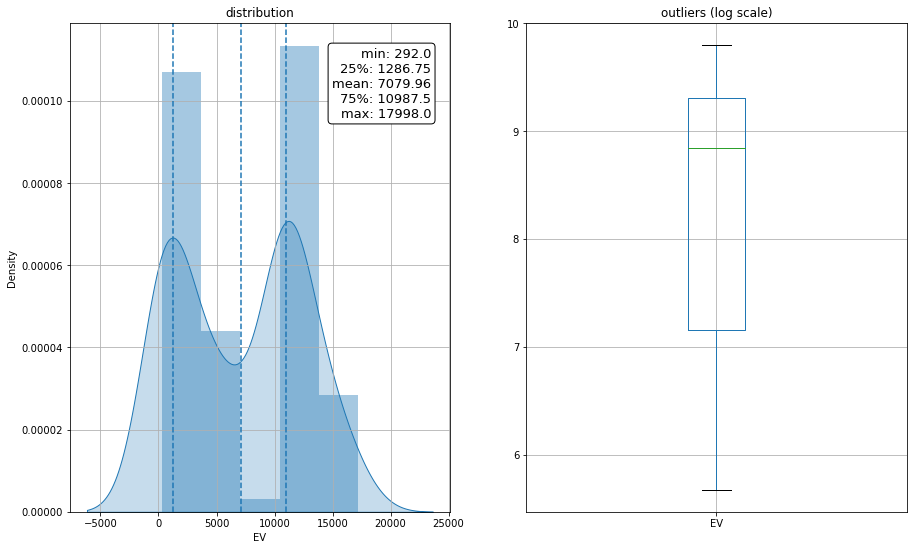

In [26]:
x = "EV"

fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
#fig.suptitle(x, fontsize=40)

### distribution
ax[0].title.set_text('distribution')
variable = reg_ev_sum[x].fillna(reg_ev_sum[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = reg_ev_sum[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=13, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_dtf = pd.DataFrame(reg_ev_sum[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1])

plt.rcParams['savefig.facecolor'] = 'w'
plt.gcf().set_size_inches(15, 9)
plt.savefig('data/sc/Figure5.png', bbox_inches='tight')

## Machine learning - Regression

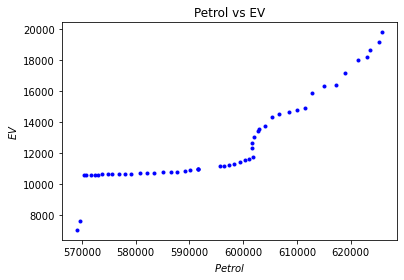

In [68]:
# Plot data
def plot_dist_mod():
    plt.figure(0)
    plt.plot(X, Y, "b.")
    plt.xlabel('$Petrol$')
    plt.ylabel('$EV$')
    plt.title('Petrol vs EV')
    #plt.ylim(12000, 19000)
    #plt.xlim(11960, 12000)
    #plt.xlim(565000, 630000)
plot_dist_mod()

In [69]:
def compute_theta_lin_reg(X, y):
    X_b = np.c_[np.ones((m,1)), X]
    theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(Y)
    return theta

In [70]:
theta = compute_theta_lin_reg(X, Y)
(theta_c, theta_m) = theta
#print("Linear regression parameters recovered analytically: intercept={0:.4f}, slope={1:.4f}".format(theta_c, theta_m))

In [71]:
def predict_lin_reg(theta, x):
    X_new_b = np.c_[np.ones((len(x), 1)), x]
    y_predict = X_new_b.dot(theta)
    y = y_predict
    return y

In [72]:
# Look at the lowest and highest number in X
print(min(X), max(X))

[569159] [625724]


In [73]:
#z = np.linspace(6500, 20000, 52)
#z = np.linspace(7770, 12010, 52)
z = np.linspace(570000, 626000, 52)

Y_pred_lin = predict_lin_reg(theta, z)

# Train model
lin_reg = LinearRegression()
lin_reg.fit(X, Y)
lin_reg.intercept_, lin_reg.coef_

(array([-80388.48096626]), array([[0.15619448]]))

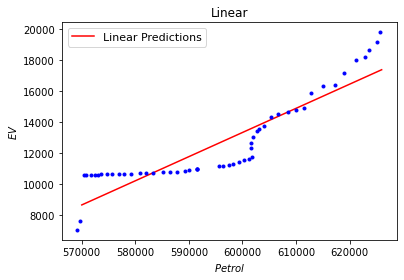

In [74]:
def plot_pred_linear():
    plt.figure(1)
    plt.plot(z, Y_pred_lin, "r-", label="Linear Predictions")
    plt.plot(X, Y, "b.")
    plt.xlabel('$Petrol$')
    plt.ylabel('$EV$')
    plt.title('Linear')
    plt.legend(loc="upper left", fontsize=11)
    #plt.ylim(7000, 20000)
    #plt.xlim(7600, 13000);
    #plt.xlim(565000, 630000);


plot_pred_linear()

## Polynomial

In [90]:
degree = 5
bias = False

from sklearn.preprocessing import PolynomialFeatures
def compute_poly_features(degree, bias):
    # Return polynomial features of samples and class
    poly_features = PolynomialFeatures(degree=degree, include_bias=bias)
    X_poly = poly_features.fit_transform(X.reshape(-1,1))
    X_sample_poly, poly_features = X.reshape(-1,1)[0], X_poly[0]
    return X_sample_poly, poly_features

X_sample_poly, poly_features = compute_poly_features(degree, bias)
poly_features = PolynomialFeatures(degree=degree, include_bias=bias)
X_poly = poly_features.fit_transform(X.reshape(-1,1))

# Train model
lin_reg_poly = LinearRegression()
lin_reg_poly.fit(X_poly, Y)
lin_reg_poly.intercept_, lin_reg_poly.coef_

(array([-643421.82481469]),
 array([[ 1.96201043e-22, -1.89589016e-14,  3.49300672e-11,
         -9.18755365e-17,  6.45313874e-23]]))

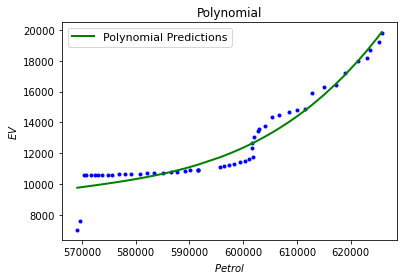

In [96]:
X_new = X.reshape(-1,1)
X_new_poly = poly_features.transform(X_new)
Y_pred_poly = lin_reg_poly.predict(X_new_poly)

def plot_pred_poly():
    plt.figure(2)
    plt.plot(X, Y, "b.")
    plt.plot(X_new, Y_pred_poly, "g-", linewidth=2, label="Polynomial Predictions")
    plt.xlabel('$Petrol$')
    plt.ylabel('$EV$')
    plt.title('Polynomial')
    #plt.ylim(12000, 19000)
    #plt.xlim(11960, 12000)
    #plt.xlim(565000, 630000)
    plt.legend(loc="upper left", fontsize=11)


plot_pred_poly()

# Over/Under-fitting

In [77]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=36)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))

    plt.figure(figsize=(8,4))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="Training set")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)   

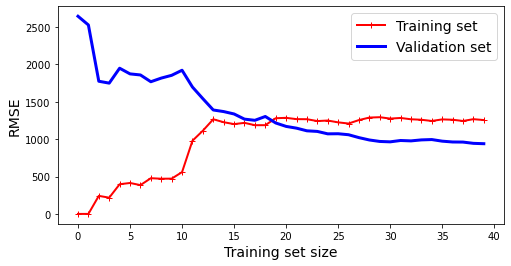

In [78]:
plot_learning_curves(lin_reg, X, Y)

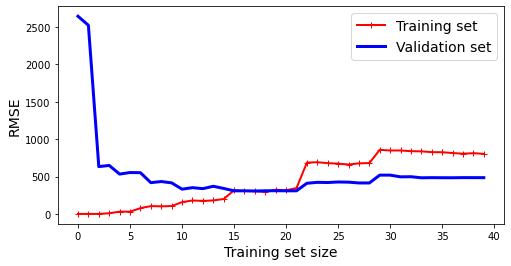

In [79]:
from sklearn.pipeline import Pipeline
polynomial_regression = Pipeline((
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ))

plot_learning_curves(polynomial_regression, X, Y)
#plt.axis([0, 2, 0, 2]);

If the RMSE for the training set is much higher than that of the test set, it is likely that you've badly underfitted the data, i.e. you've created a model that trains well in sample, but has little predictive value when trained out of sample.

# Optimisation

## Ridge vs Lasso

### Ridge

In [80]:
from sklearn.linear_model import Ridge

m = 52

def plot_model(model_class, polynomial, alphas, **model_kargs): 
    # Use alpha for regularization parameter (lambda used already)
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline((
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ))
        model.fit(X, Y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\lambda = {}$".format(alpha))
    plt.plot(X, Y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    #plt.axis([0, 3, 0, 4])

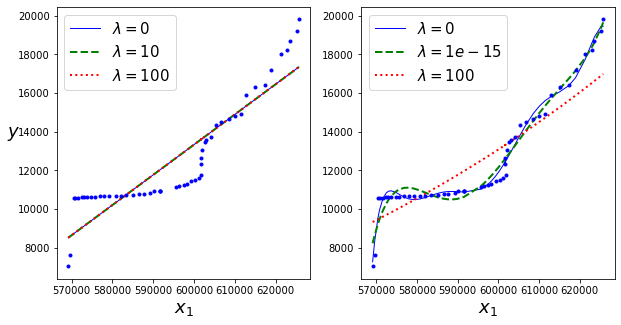

In [102]:
from sklearn.preprocessing import StandardScaler
plt.figure(figsize=(10,5))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-15, 100), random_state=42)

### Lasso

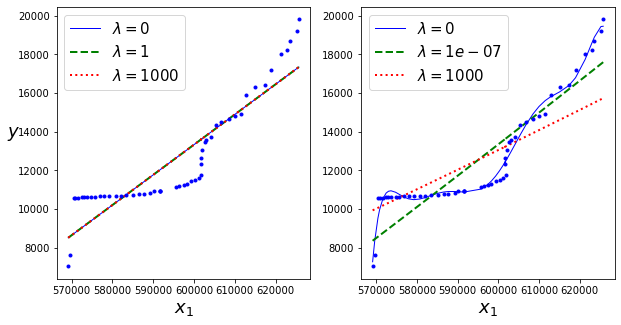

In [82]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(10,5))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 1, 1000), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1000), tol=1, random_state=42)

## Optimising by Ridge

In [103]:
from sklearn.linear_model import Ridge

ridgereg = Ridge(alpha=10**-15)
ridgereg.fit(X_poly, Y)
Y_pred_poly_improved = ridgereg.predict(X_new_poly)
Y_pred_poly_improved = Y_pred_poly_improved.ravel()

/opt/conda/envs/sds2020/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.05334e-62): result may not be accurate.
  overwrite_a=True).T


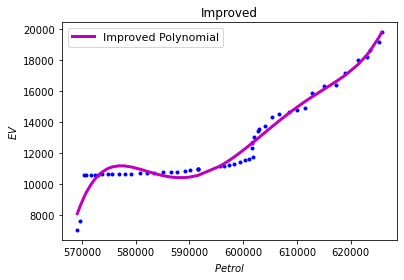

In [104]:
def plot_pred_improved():
    plt.figure(3)
    plt.plot(X, Y, "b.")
    plt.plot(X_new, Y_pred_poly_improved, "m-", linewidth=3, label="Improved Polynomial")
    plt.xlabel('$Petrol$')
    plt.ylabel('$EV$')
    plt.title('Improved')
    plt.legend(loc="upper left", fontsize=11)
    #plt.ylim(12000, 19000)
    #plt.xlim(11960, 12000)
    #plt.xlim(600000, 630000)

plot_pred_improved()

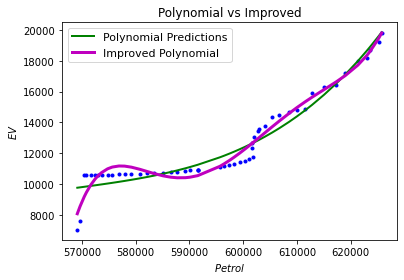

In [105]:
plt.figure()
plt.plot(X, Y, "b.")
plt.plot(X_new, Y_pred_poly, "g-", linewidth=2, label="Polynomial Predictions")
plt.plot(X_new, Y_pred_poly_improved, "m-", linewidth=3, label="Improved Polynomial")
plt.xlabel('$Petrol$')
plt.ylabel('$EV$')
plt.title('Polynomial vs Improved')
plt.legend(loc="upper left", fontsize=11)
#plt.ylim(12000, 19000)
#plt.xlim(600000, 630000)

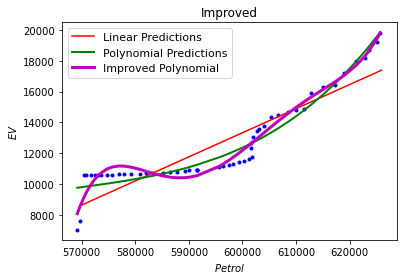

In [106]:
plt.figure()
plt.plot(X, Y, "b.")
plt.plot(z, Y_pred_lin, "r-", label="Linear Predictions")
plt.plot(X_new, Y_pred_poly, "g-", linewidth=2, label="Polynomial Predictions")
plt.plot(X_new, Y_pred_poly_improved, "m-", linewidth=3, label="Improved Polynomial")
plt.xlabel('$Petrol$')
plt.ylabel('$EV$')
plt.title('Improved')
plt.legend(loc="upper left", fontsize=11)
#plt.ylim(12000, 19000)
#plt.xlim(600000, 630000)

For the linear prediction, it shows a less accuracy in terms of the comparison with the actual data. This model contains a larger gap between the predicted points and actual points, too high bias could lead to a potential underfitted issue. It is too regularized and it may only able to provide a general overview and trend of the data. For the polynomial model, it relatively better describes and predicts the shape of the data. The prediction line is followed based on the polynomial features. However, it contains a high level of noises. it could have a overfitting issue as there are too high expected ability of the model to fluctuate (high variance).

In [87]:
# Define a general function to compute the RMS error

def compute_rms(Y_1, Y_2):
    from sklearn.metrics import mean_squared_error
    from math import sqrt
    rms = sqrt(mean_squared_error(Y_1, Y_2))
    return rms

In [107]:
# Compute the RMS error between the data and the predictions for each model.

rms_lin = compute_rms(Y, Y_pred_lin)
rms_poly = compute_rms(Y, Y_pred_poly)
rms_poly_improved = compute_rms(Y, Y_pred_poly_improved)

In [108]:
# Print RMS values computed.
print("rms_lin = {0:.4f}".format(rms_lin))
print("rms_poly = {0:.4f}".format(rms_poly))
print("rms_poly_improved = {0:.4f}".format(rms_poly_improved))

rms_lin = 1306.8792
rms_poly = 722.1913
rms_poly_improved = 496.6244


The Root Mean Sqaure Error (RMSE) enables to estimate the standard deviation of the distribution of our errors. It measuring the distance between the predicted point and actual point. The lower RMS shows the better fit of the model comparing to the predication.

Among all three modelling, the highest rms is the linear predication method (1306.9792), indicating that the distance between predicted and actual values are largely farther than the polynomial approach. A higher variance could affect users to precisely forecast the trend of the electric vehicle data. 

The polynomial model helped to drop the RMSE to around 722, which allows the predicted point singificantly closer to the actual data. The prediction line was followed based on the polynomial features. However, due to the insufficient data collection, the performance of the polynomial prediction could be affect by a level of noises. When more unseen data is being placed in the model, the prediction line is likely to be drawn followed by the data. Consequently, it could have a overfitting issue as there are too high expected ability of the model to fluctuate (high variance).

The improved polynomial model would be the preferable method for prediction, with 496.6244 RMSE. In which, the RSME has approximately four times smaller than the linear model. It demonstrates that the ridge model is more accurate to predict the response and effectively reduce model complexity, further shows its suitabilty on understanding such low dimensional dataset. As lower RMS show the better fit of model, therefore the improved polynomial (Ridge) model is the best for predicting the EV trend.